In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
from statistics import mode
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [5]:
# SET50 (unrealize)
SET50 = ['ADVANC', 'AOT', 'BANPU', 'BBL', 'BCP', 'BDMS',
        'BEM', 'BH', 'BJC', 'BTS', 'CENTEL', 'CPALL', 
         'CPF', 'CPN', 'DTAC', 'EGCO', 'HMPRO', 
         'INTUCH', 'IRPC', 'KBANK', 'KCE', 'KKP', 'KTB', 'LH', 'MINT', 'PTT',
        'PTTEP', 'ROBINS', 'SCB', 'SCC', 
        'TCAP', 'TISCO', 'TMB', 'TOP', 'TRUE', 'TU']

# remove (low data) : TPIPP WHA SPRC SAWAD PSH MTLS IVL GPSC EA CBG BPP BEAUTY PTTGC

In [9]:
def load_stock_data(symbol, year_start, year_end):
    stock_data = []
    with open('../Data set/FIXED_SET50/' + symbol + '.BK.csv', 'r') as csv_file:
        file_data = csv.reader(csv_file, delimiter=',')
        file_data = list(file_data)[1:]
        temp_value = 0
        for row in file_data:
            if row[1] is '':
                continue
            elif int(row[0][0:4]) >= year_start and int(row[0][0:4]) <= year_end:
                temp = float(row[1])
                if temp_value != 0:
                    unrealize = (temp - temp_value)/ temp_value
                else:
                    unrealize = 0
                unrealize = ["{0:.4f}".format(unrealize)]
                stock_data.append(unrealize)
                temp_value = temp
                
    return stock_data

def mean_square_error(actual, predict):
    length = len(actual)
    sums_error = 0.0
    for i, j in zip(actual, predict):
        sums_error += (i - j)**2
    
    return sums_error / length

def findNewXTest(x_test, predict):
    for (index, element) in enumerate(x_test[0]):
        for i in range(len(element)):
            if i == 0:
                continue
            elif i < 29:
                element[i - 1] = element[i]
            else:
                element[i - 1] = element[i]
                element[i] = "{0:.4f}".format(predict[index])
    return x_test

In [10]:
stock_datas = [ load_stock_data(x, 2008, 2017) for x in SET50 ]

min_count = len(stock_datas[0])

In [11]:
def create_model(conv_count, fully_count):
    i = 0
    model = Sequential()
    while(i <= conv_count):
        if i == 0:
            model.add(Conv2D(64, (7, 1), input_shape=(len(stock_datas), 30, 1), padding='same'))
        else:
            model.add(Conv2D(32, (3, 1)))
            
        model.add(Activation('tanh'))
        model.add(MaxPooling2D(pool_size = (2, 1), data_format= "channels_last"))
        i += 1
        
    i = 0
    model.add(Flatten())
    
    while(i <= fully_count):
        if i == fully_count:
            model.add(Dropout(0.2))
            model.add(Dense(len(stock_datas)))
        else:
            model.add(Dense(256))  
            model.add(Activation('tanh'))
        i += 1
    
    return model

In [12]:
size = 1
models = [create_model(int(_/3), _%3) for _ in range(size)]
# (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) ... (2, 5)
# first for conv, second for fully connected

In [13]:
lr = 0.95
decay = 1e-6

In [14]:
optimizer = SGD(lr=lr, decay=decay)
for model in models:
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae'])

In [15]:
rounds = min_count - 30
train_index = int(rounds * 0.75)
validate_index = train_index + int(rounds * 0.05)

In [16]:
data = []
count = 0
index = 0
while index < rounds:
    temp = [i[index : index + 30] for i in stock_datas]
    data.append(temp)
    index += 1
    
x = np.asarray(data)
x_train = x[0: train_index].astype('float32')
x_validate = x[train_index: validate_index].astype('float32')
x_test = x[validate_index: rounds].astype('float32')

print(x_train.shape, x_validate.shape, x_test.shape)

(2052, 36, 30, 1) (120, 36, 30, 1) (243, 36, 30, 1)


In [17]:
target = []
index = 0
while index < rounds:
    temp = [stock_datas[i][index + 30][0] for i in range(len(stock_datas))]
    target.append(temp)
    index += 1
    
y = np.asarray(target)
y_train = y[0: train_index].astype('float32')
y_validate = y[train_index: validate_index].astype('float32')
y_test = y[validate_index: rounds].astype('float32')

print(y_train.shape, y_validate.shape, y_test.shape)

(2052, 36) (120, 36) (243, 36)


In [18]:
epochs = 20

for (index, model) in enumerate(models):
    print(index)
    model.fit(x_train, y_train, validation_data = (x_validate, y_validate), epochs = epochs, batch_size = 1, verbose= 1)
    

0
Train on 2052 samples, validate on 120 samples
Epoch 1/20
2052/2052 [==============================] - 42s 20ms/step - loss: 8.3600e-04 - acc: 0.0390 - mean_absolute_error: 0.0155 - val_loss: 2.4056e-04 - val_acc: 0.0417 - val_mean_absolute_error: 0.0111
Epoch 2/20
2052/2052 [==============================] - 16s 8ms/step - loss: 7.3982e-04 - acc: 0.0507 - mean_absolute_error: 0.0148 - val_loss: 2.2742e-04 - val_acc: 0.0583 - val_mean_absolute_error: 0.0107
Epoch 3/20
2052/2052 [==============================] - 16s 8ms/step - loss: 7.0655e-04 - acc: 0.0604 - mean_absolute_error: 0.0144 - val_loss: 2.2118e-04 - val_acc: 0.0500 - val_mean_absolute_error: 0.0106
Epoch 4/20
2052/2052 [==============================] - 16s 8ms/step - loss: 6.8152e-04 - acc: 0.0746 - mean_absolute_error: 0.0142 - val_loss: 2.2040e-04 - val_acc: 0.0333 - val_mean_absolute_error: 0.0106
Epoch 5/20
2052/2052 [==============================] - 16s 8ms/step - loss: 6.5977e-04 - acc: 0.0819 - mean_absolute_erro

In [ ]:
for model in models:

In [19]:
predicts = [[] for i in range(size)]
for i in range(size):
    test_data = x_test.copy()
    for (index, element) in enumerate(y_test):
        predict = models[i].predict(test_data, verbose = 0)
        predicts[i].append(predict[0])
        test_data = findNewXTest(test_data, predict[0])

In [20]:
predicts = [np.asarray(predict).astype('float32') for predict in predicts]

In [21]:
def plot_graph(array1, array4):
    plt.figure(figsize=(20,10))
    x_axis = [i for i in range(len(array1))]
    plt.plot(x_axis, array1, 'g')
    plt.plot(x_axis, array4, 'y')

    plt.show()
    
def get_data_from_nparray(nparray, index):
    return_data = [i[index] for i in nparray]
    return return_data

ADVANC


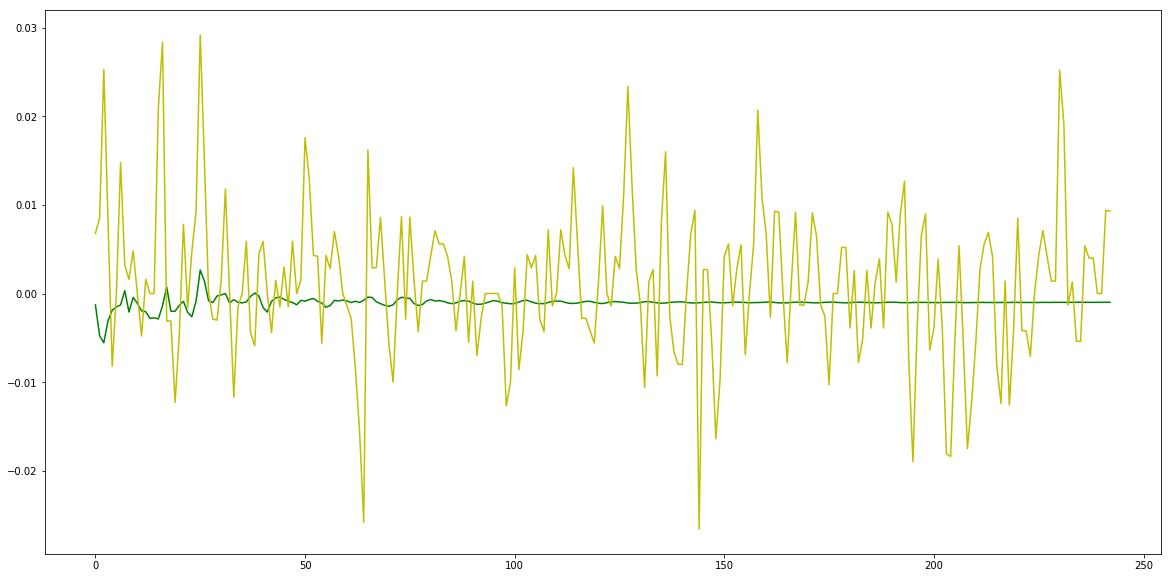

AOT


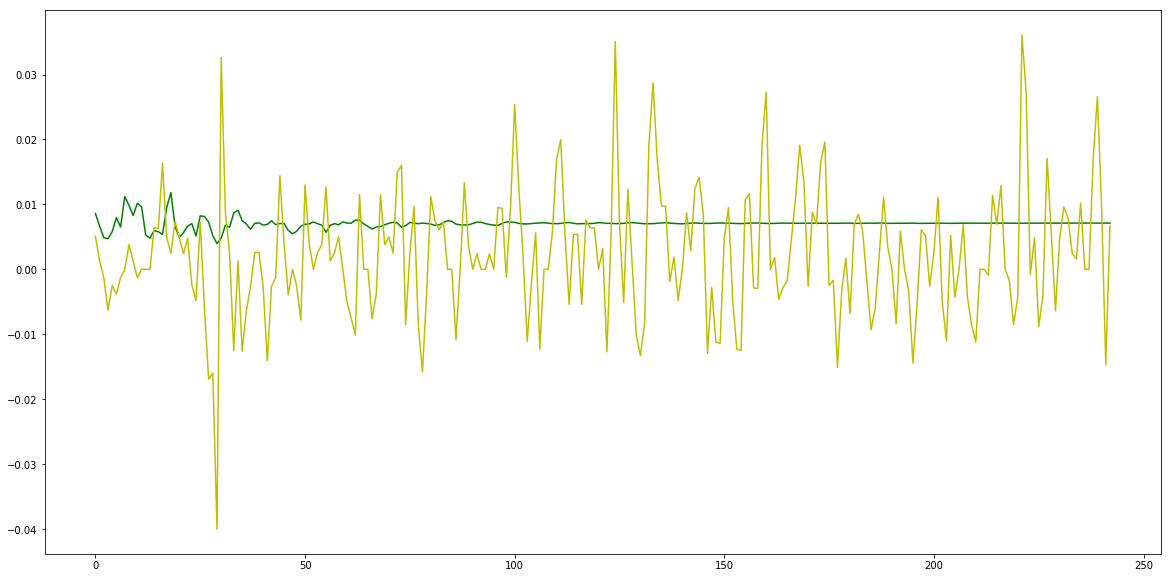

BANPU


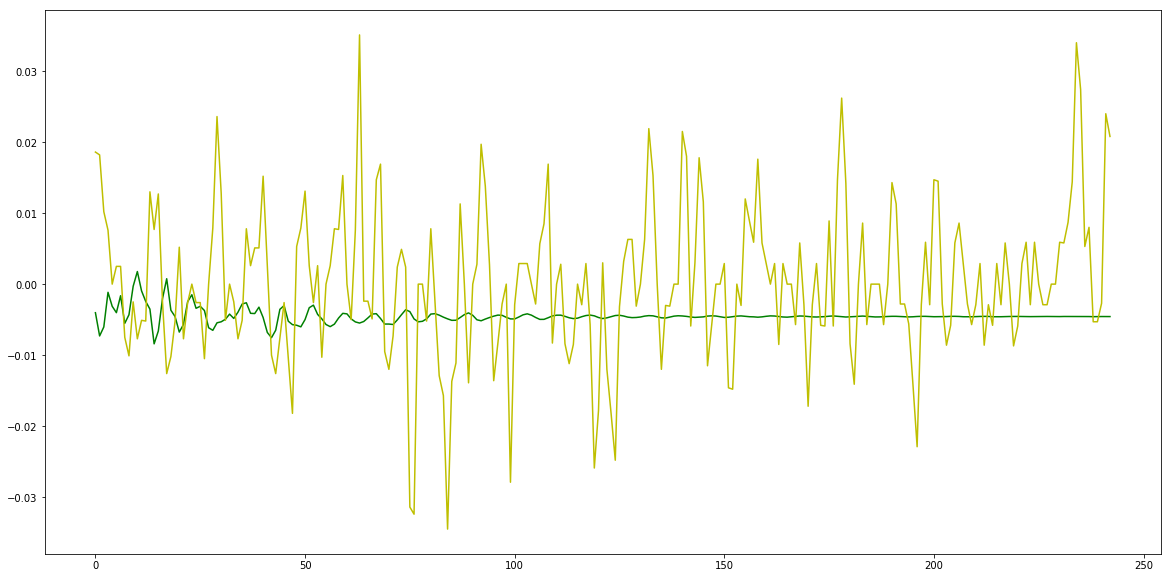

BBL


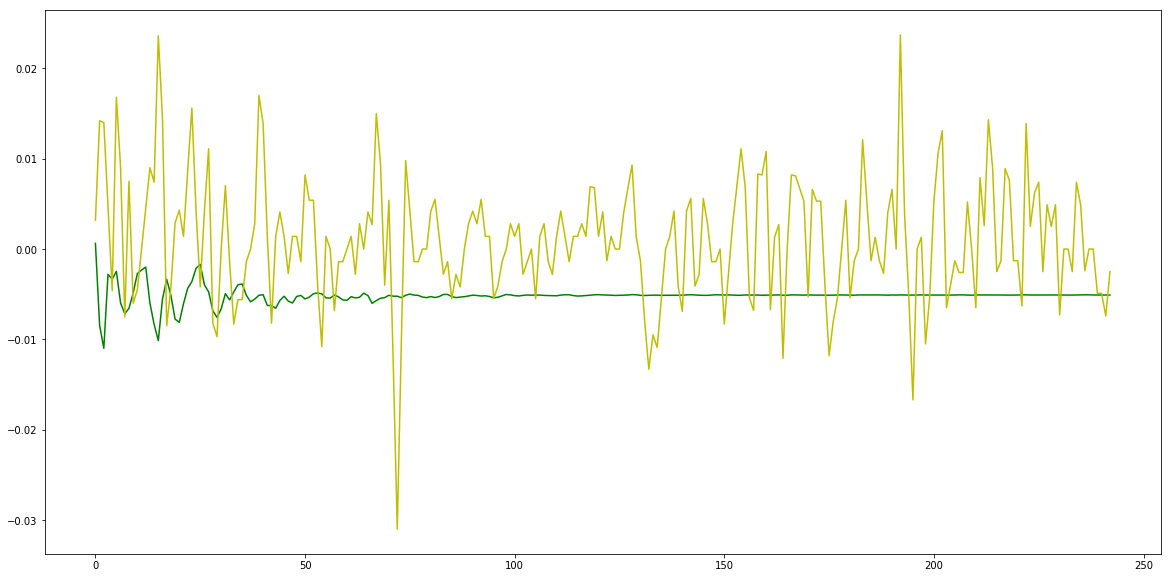

BCP


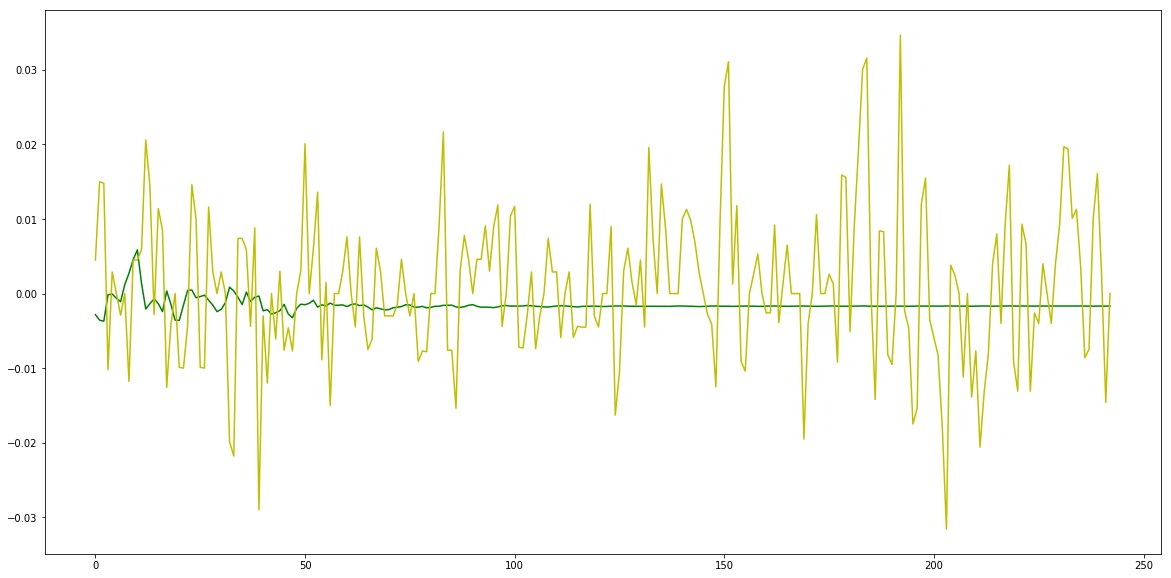

BDMS


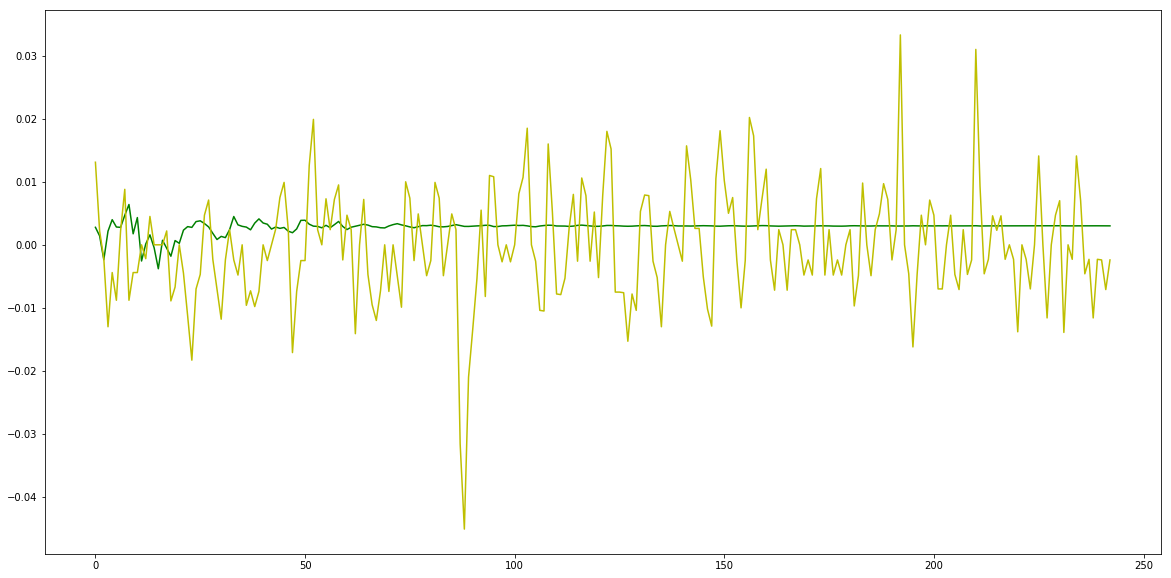

BEM


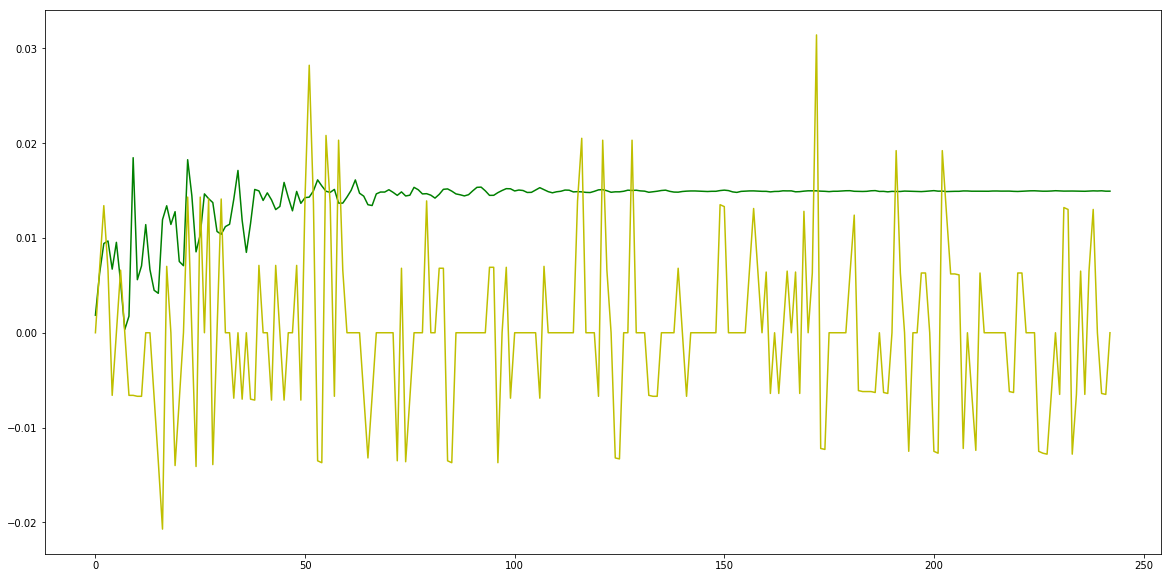

BH


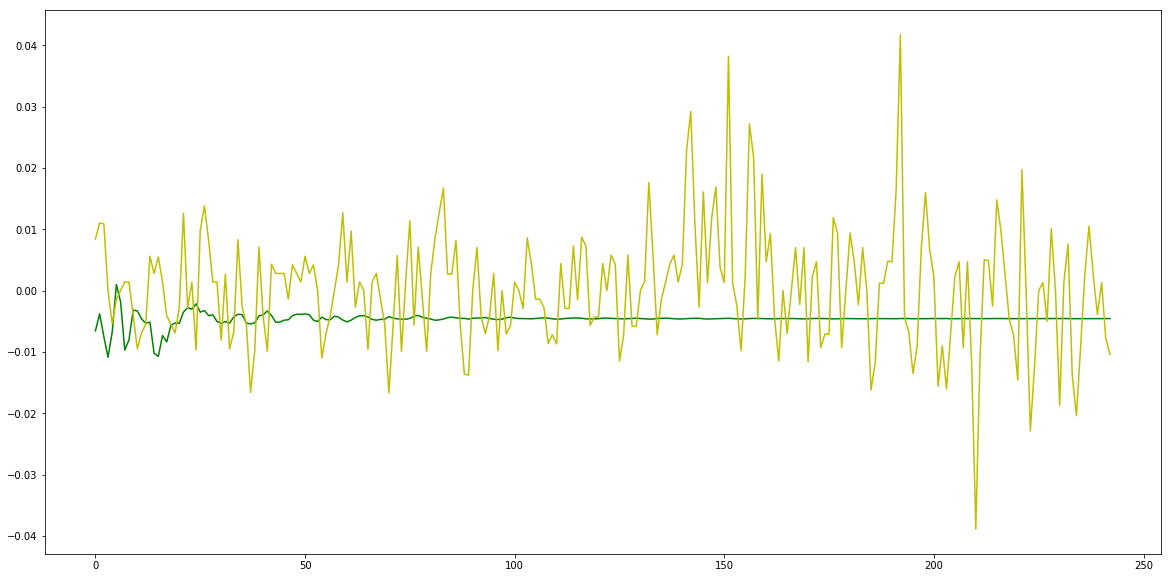

BJC


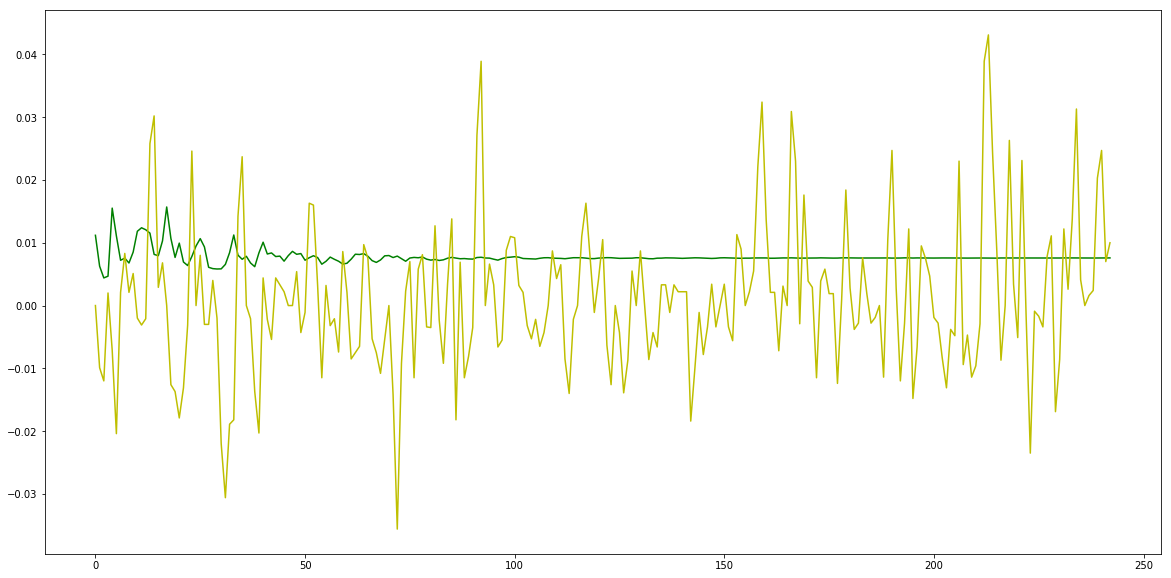

BTS


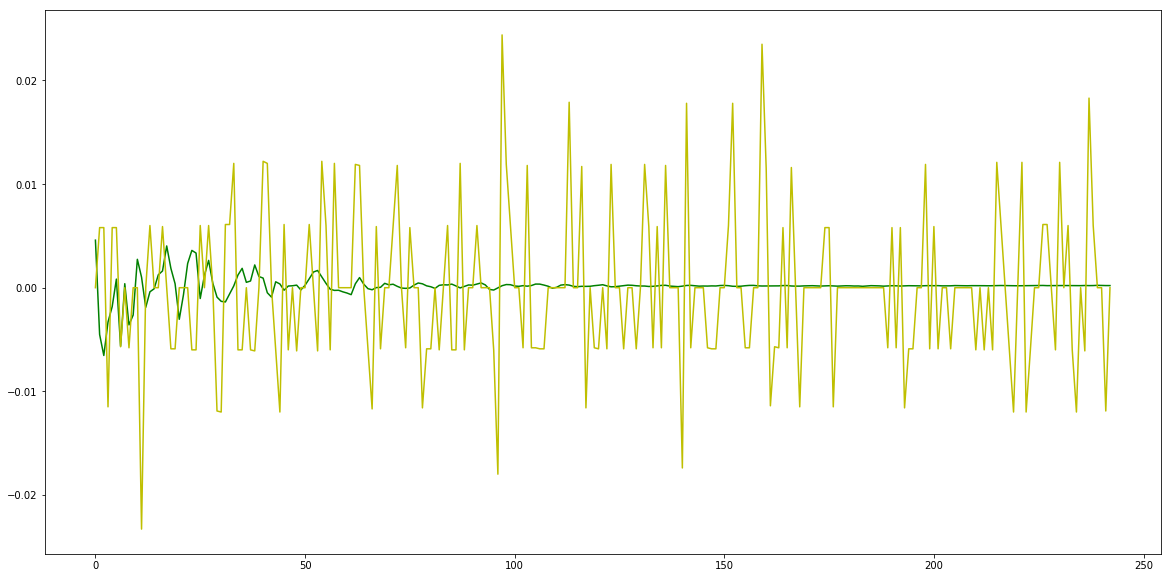

CENTEL


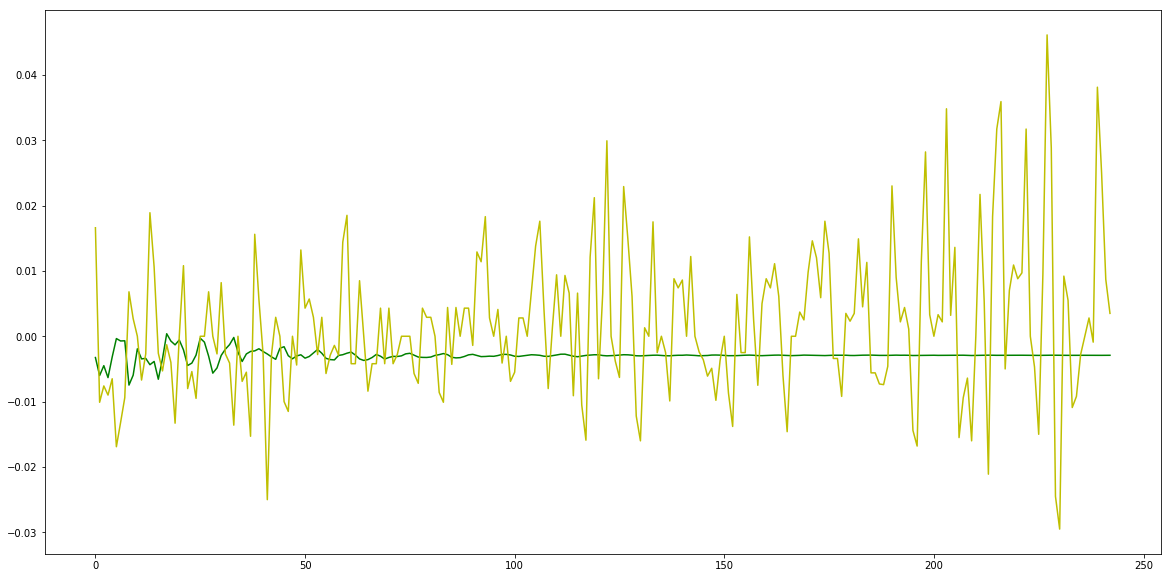

CPALL


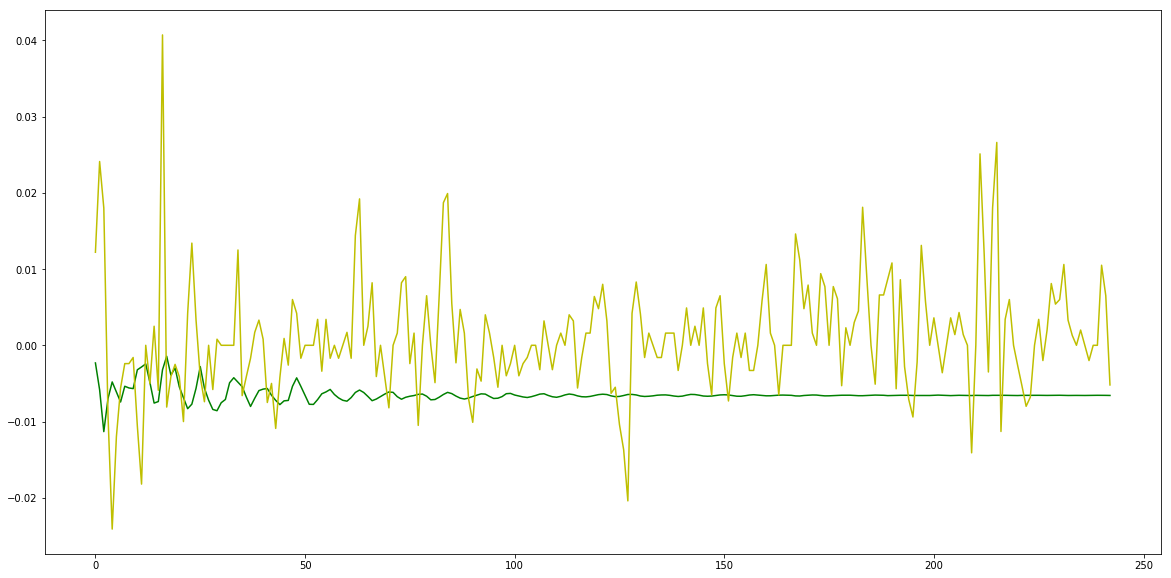

CPF


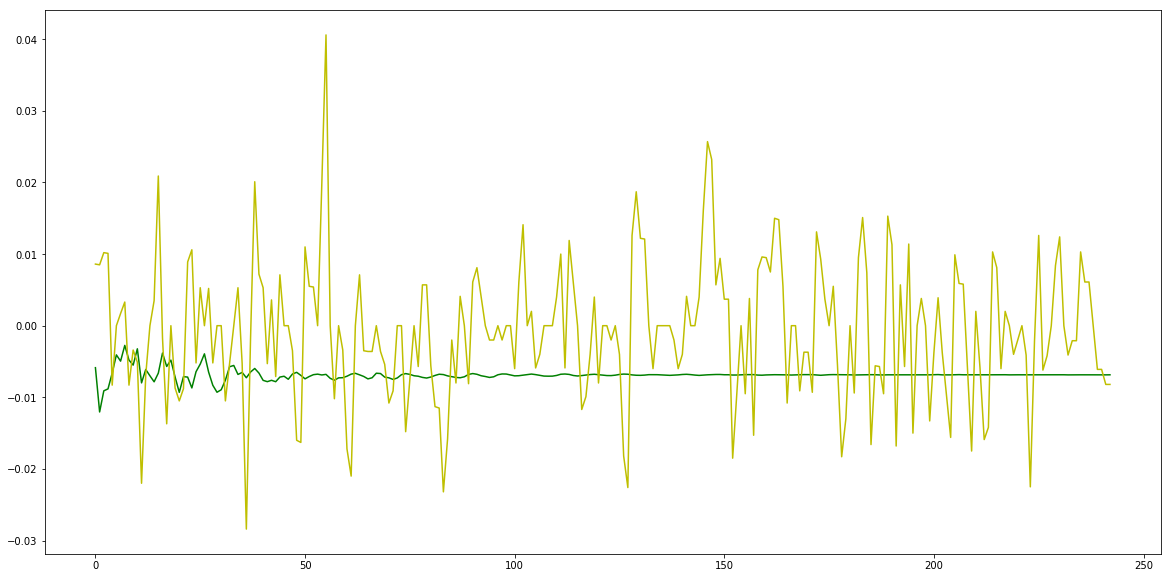

CPN


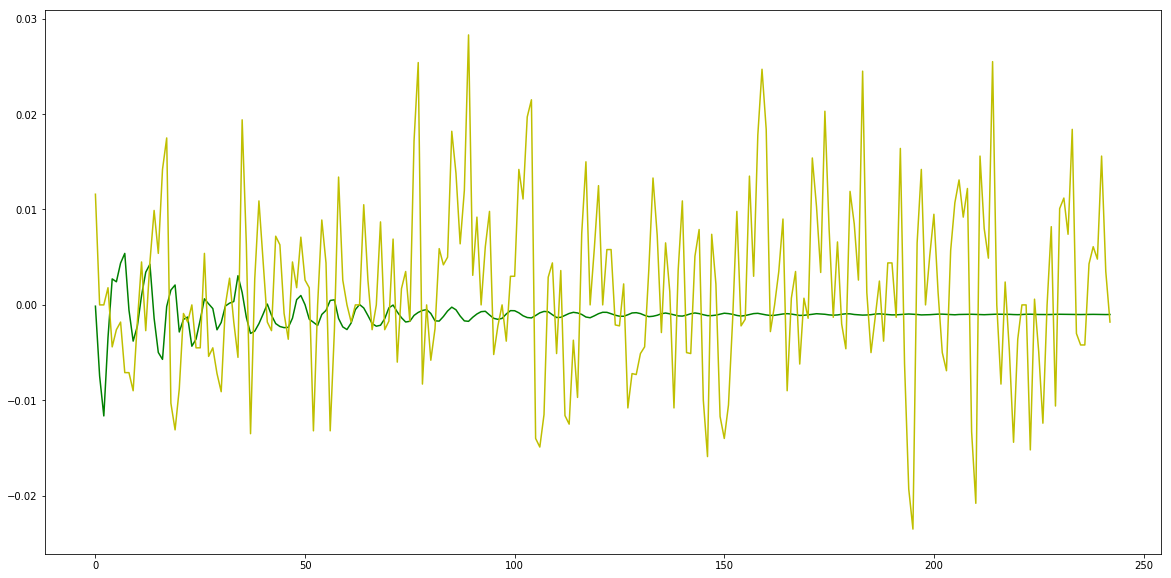

DTAC


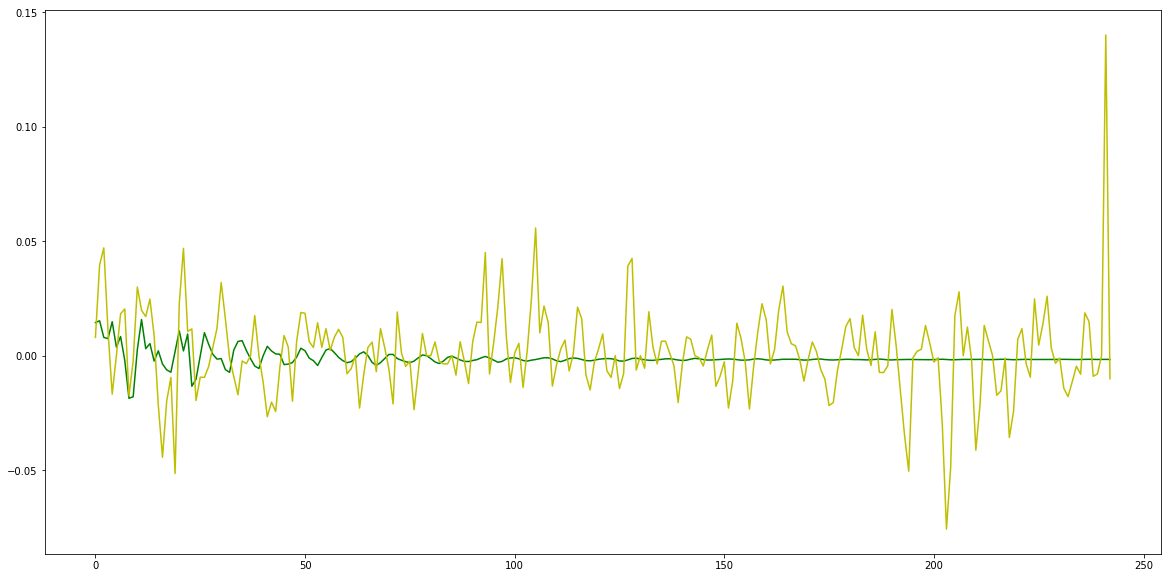

EGCO


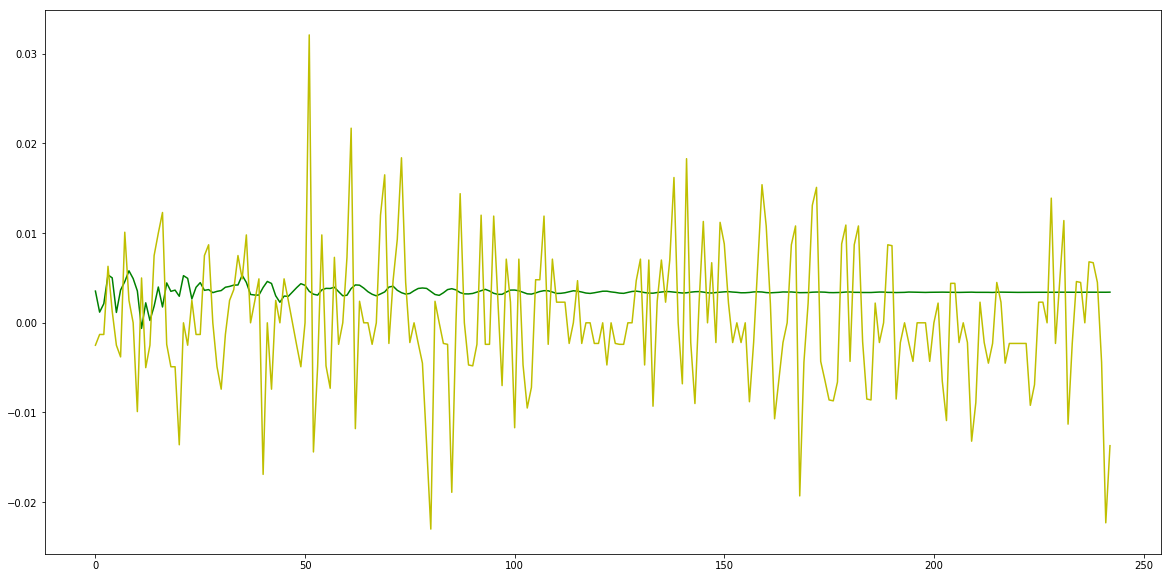

HMPRO


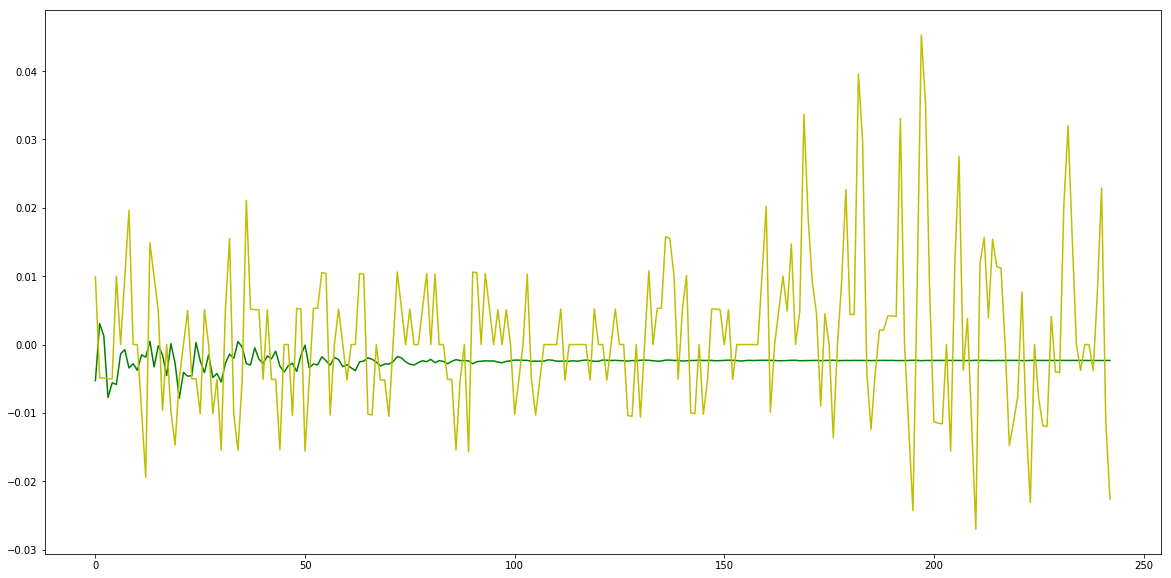

INTUCH


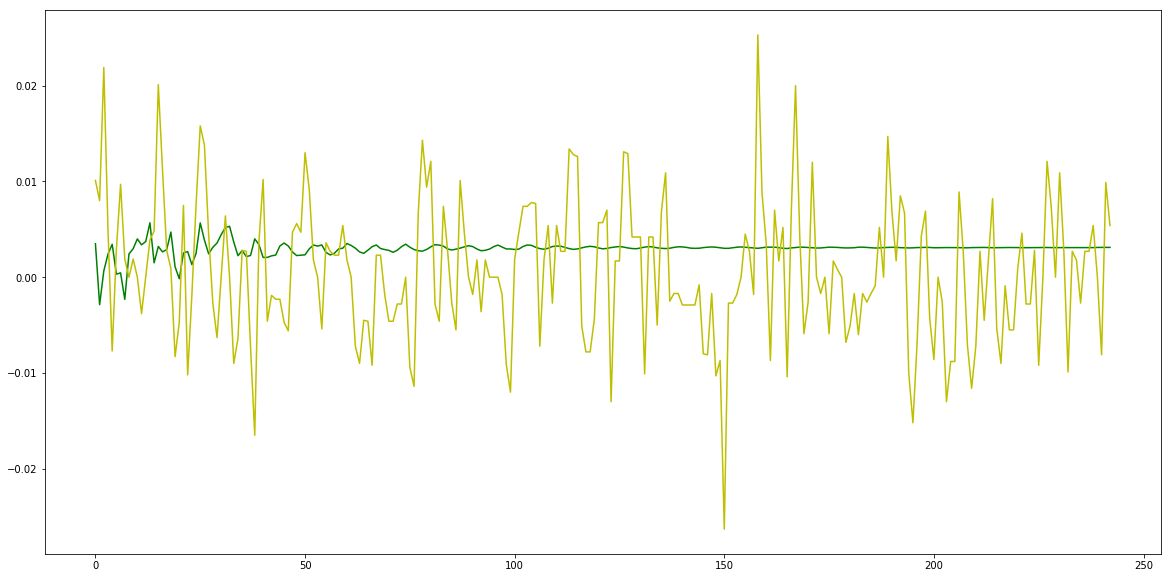

IRPC


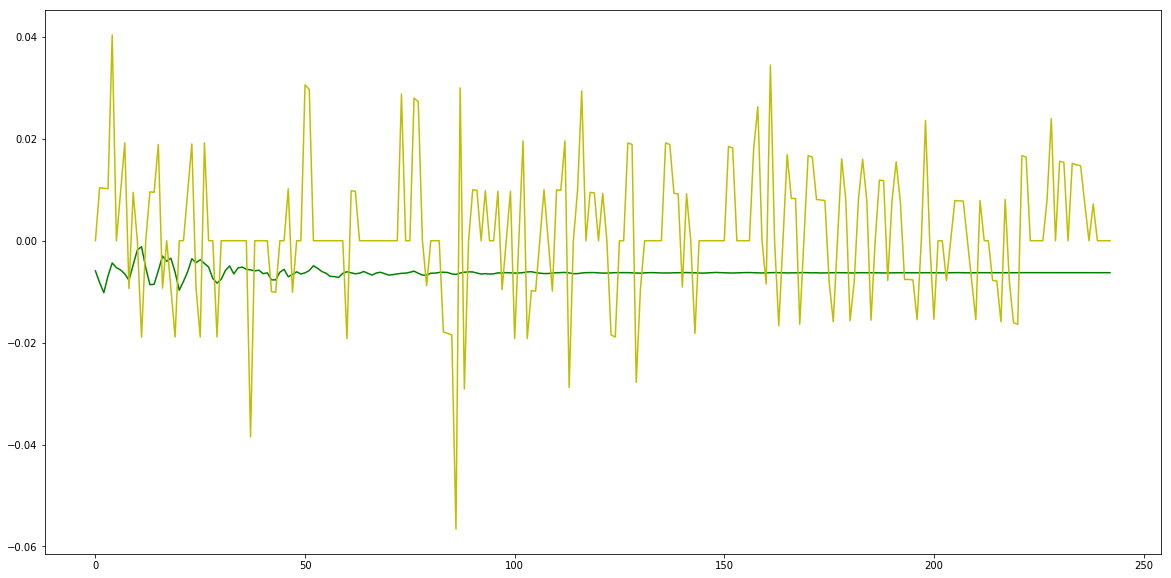

KBANK


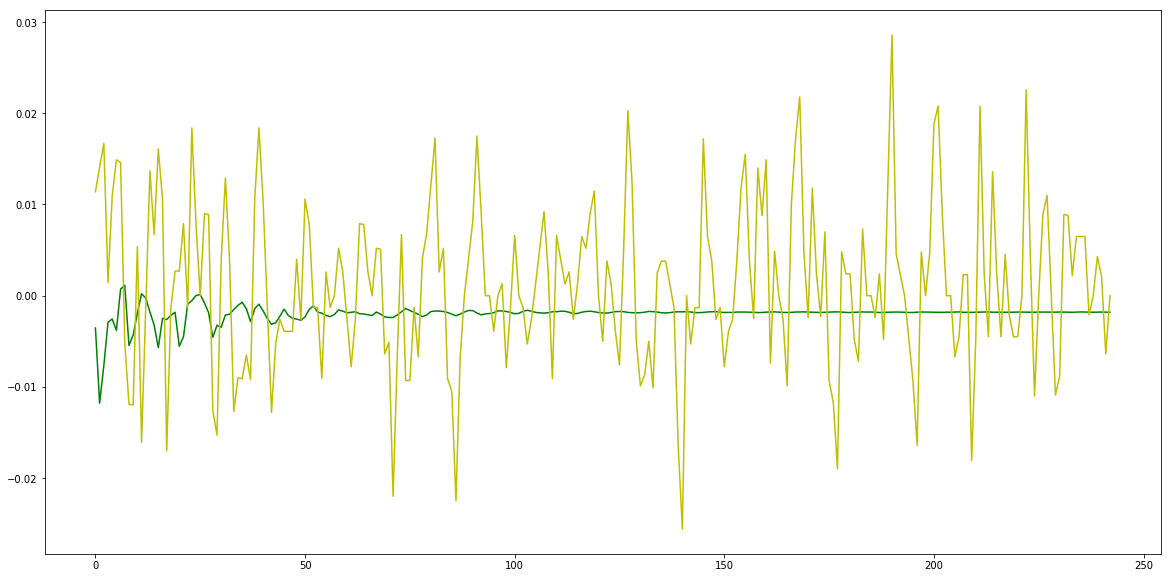

KCE


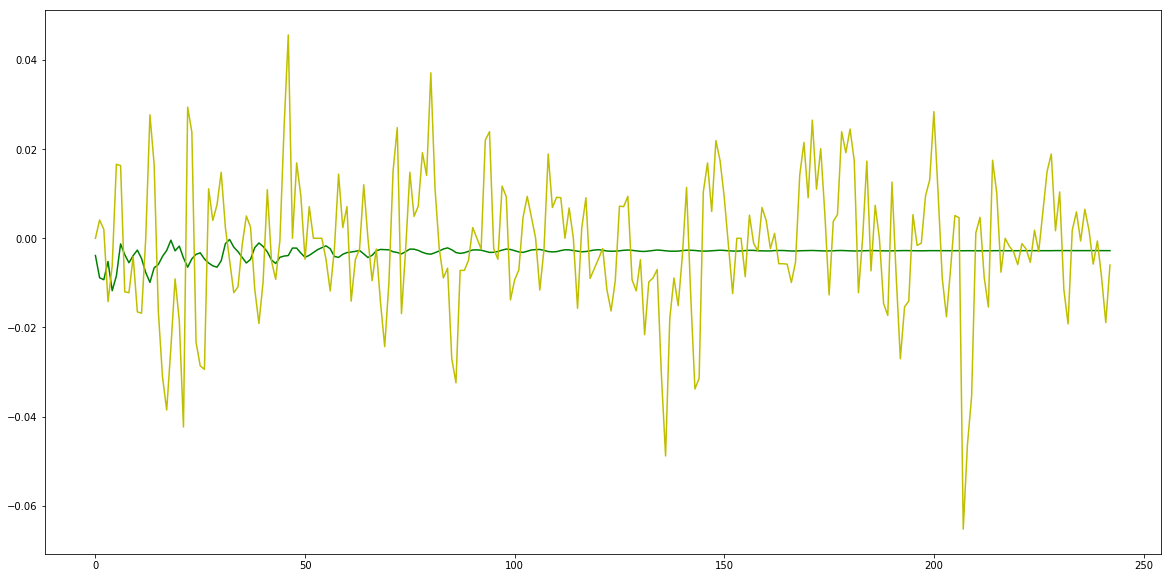

KKP


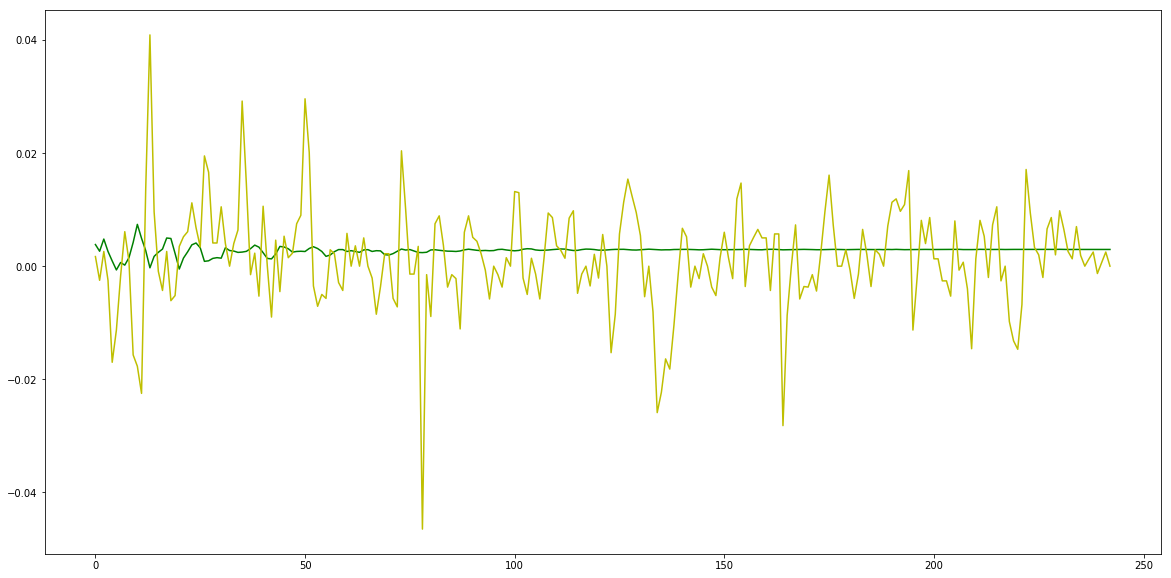

KTB


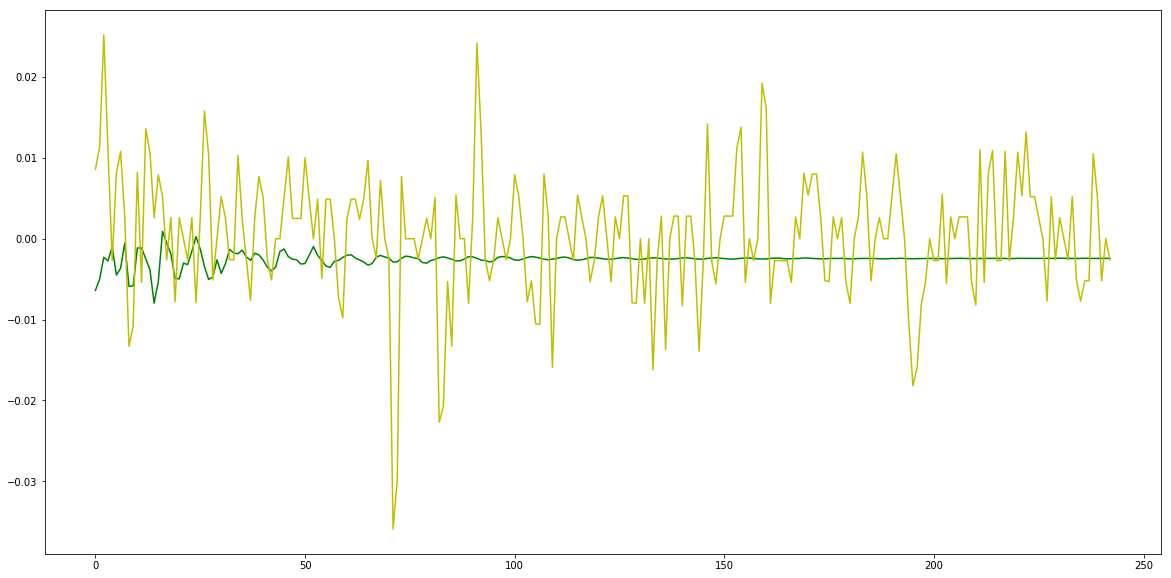

LH


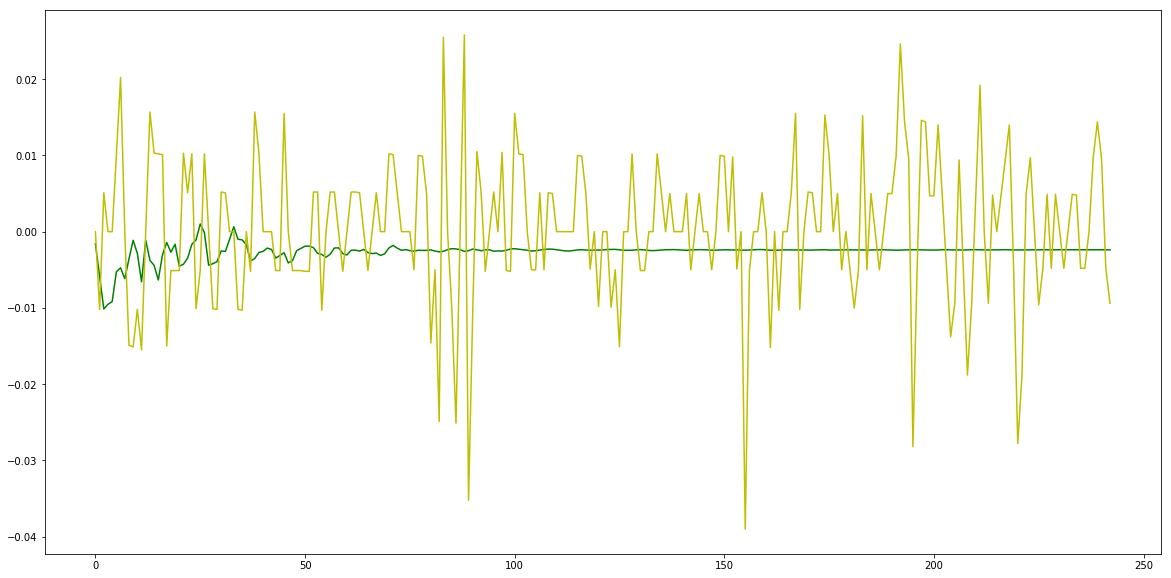

MINT


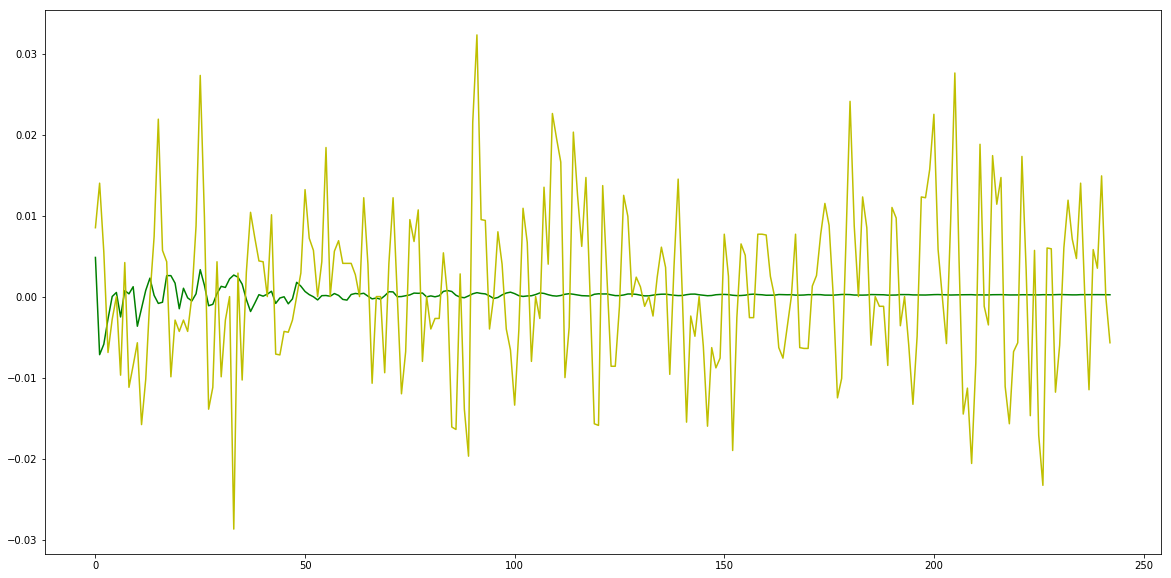

PTT


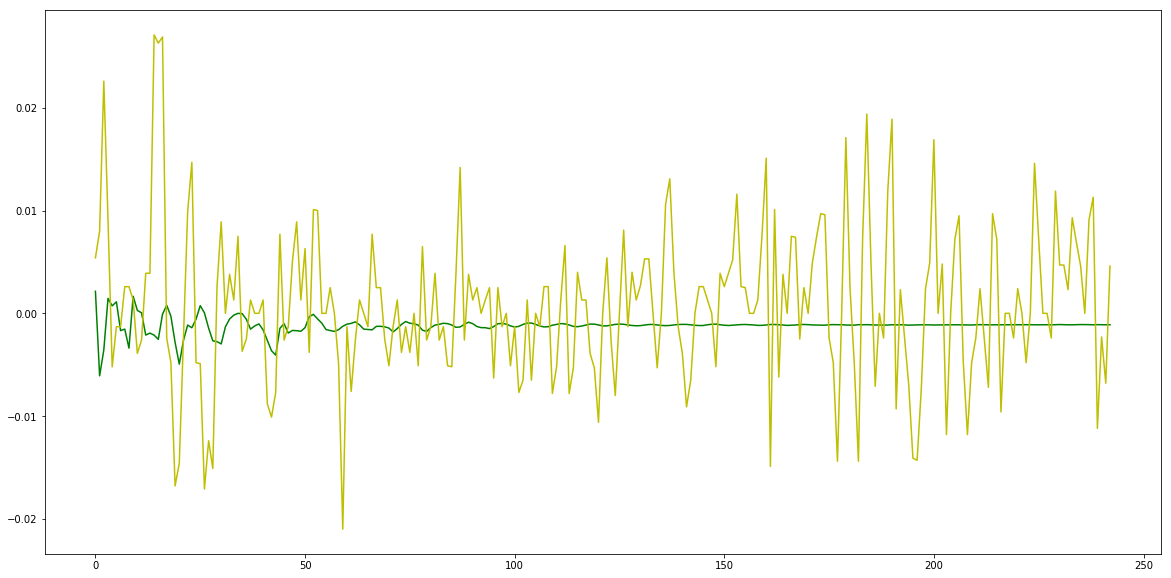

PTTEP


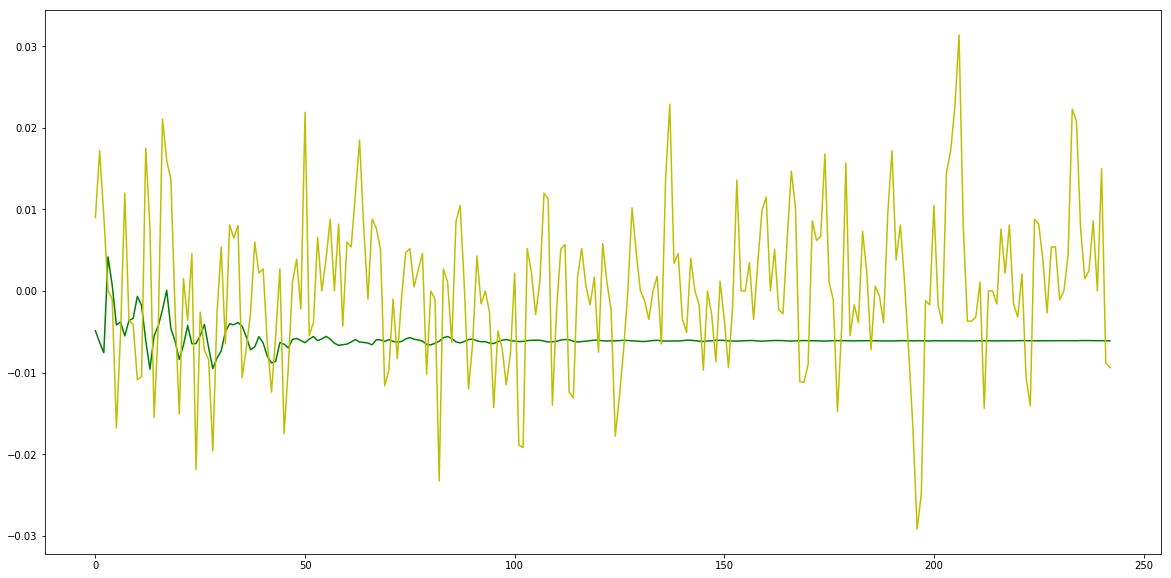

ROBINS


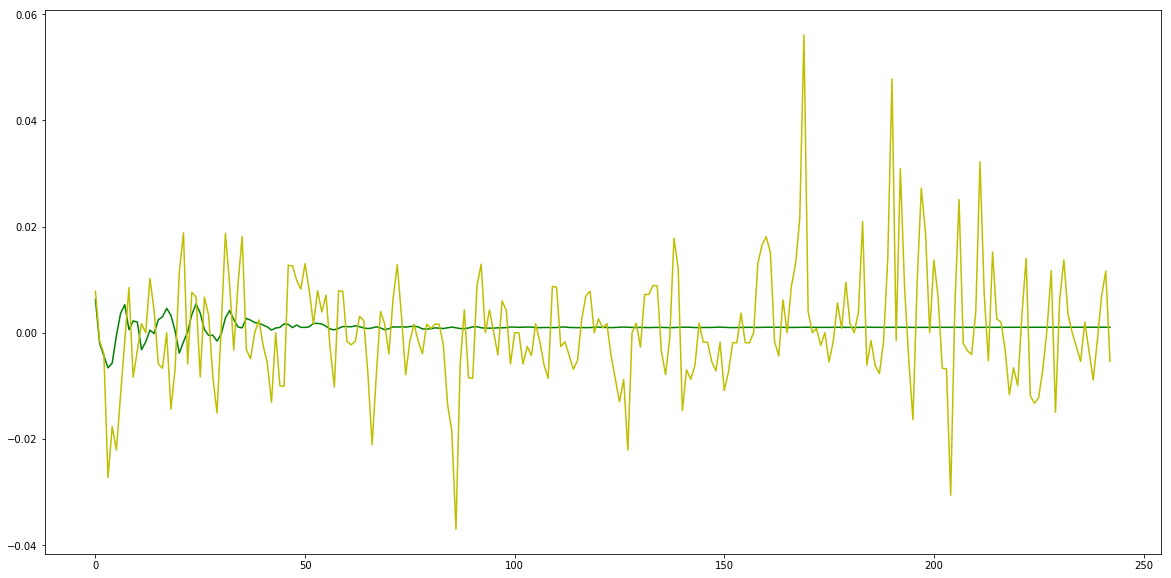

SCB


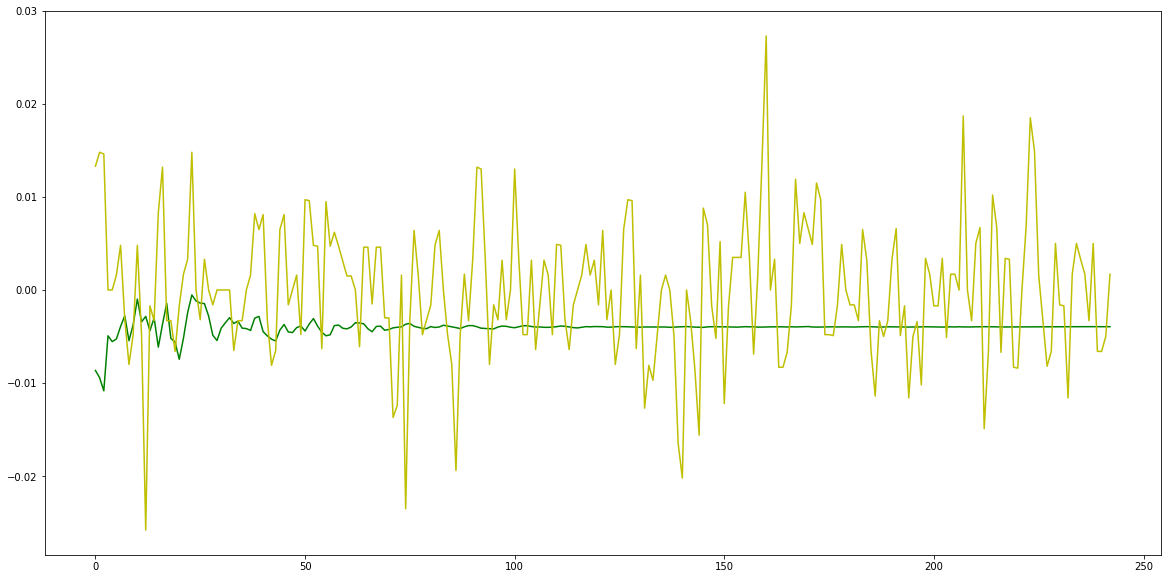

SCC


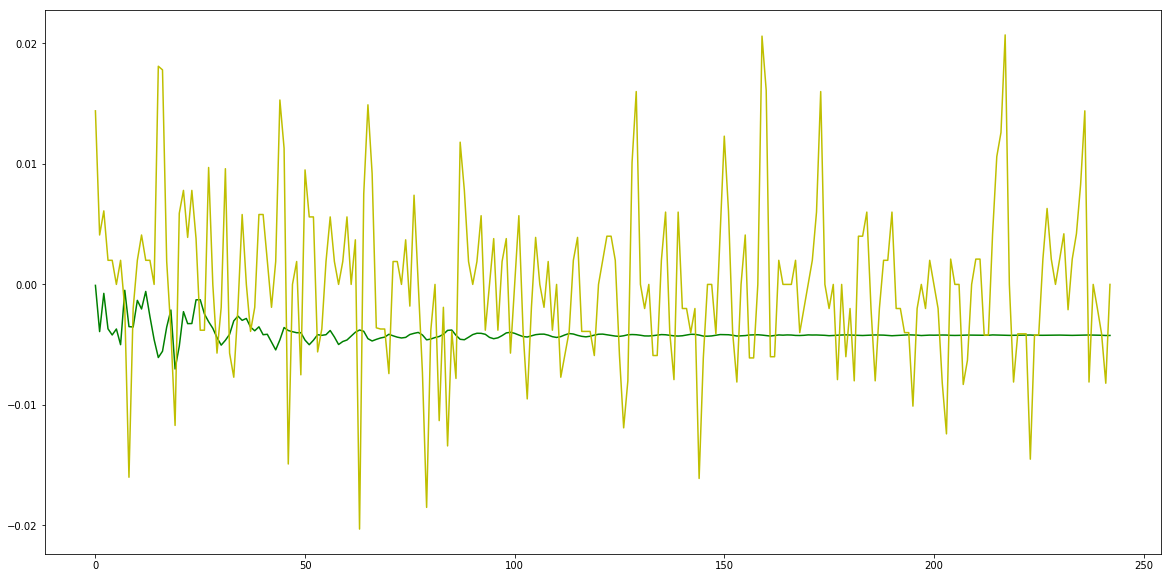

TCAP


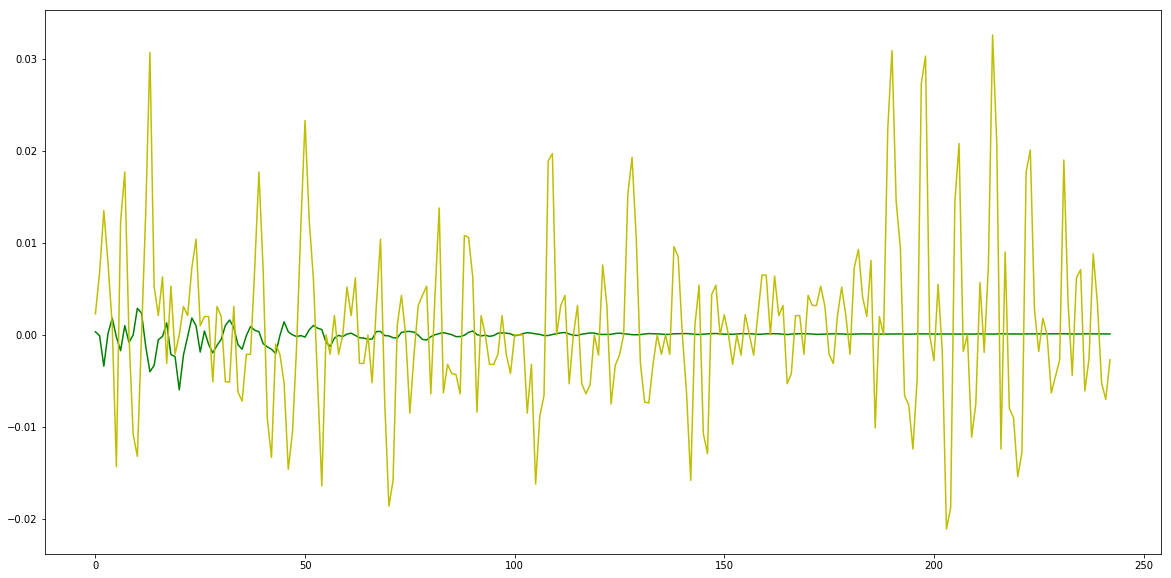

TISCO


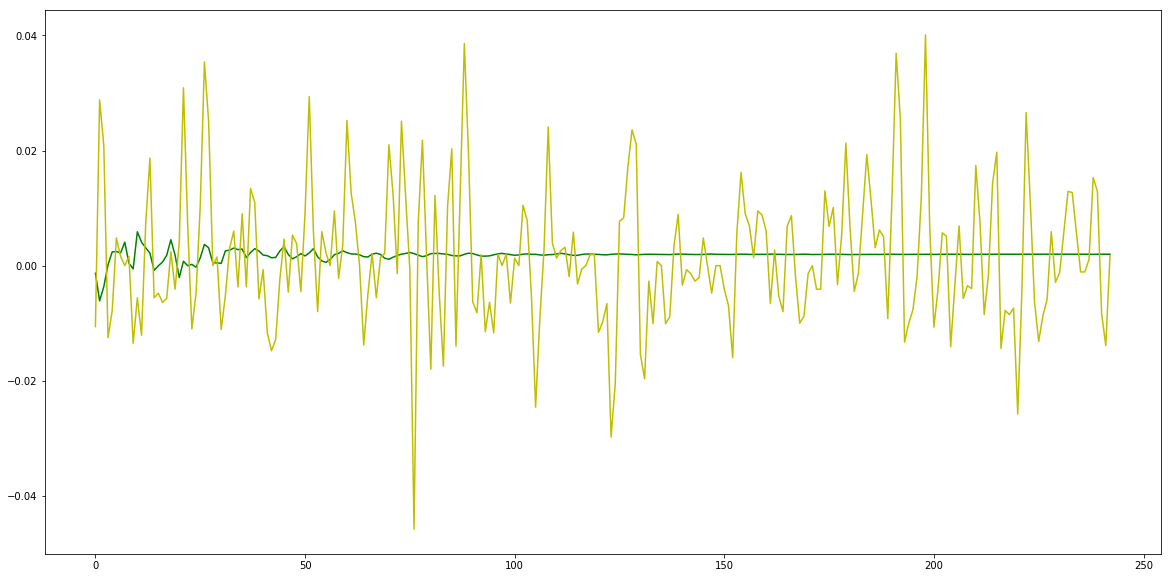

TMB


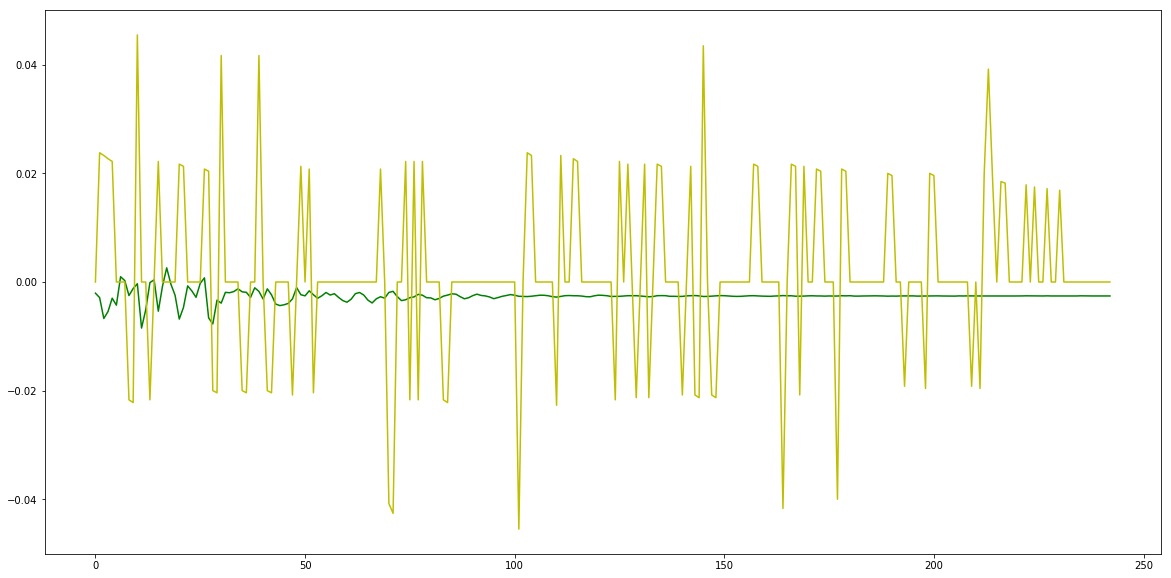

TOP


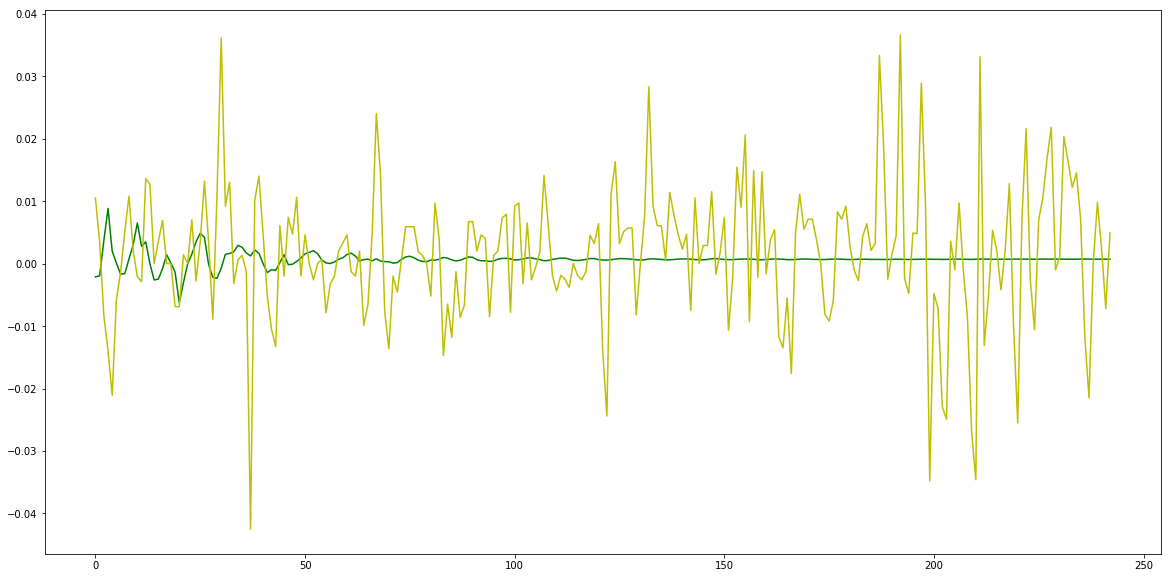

TRUE


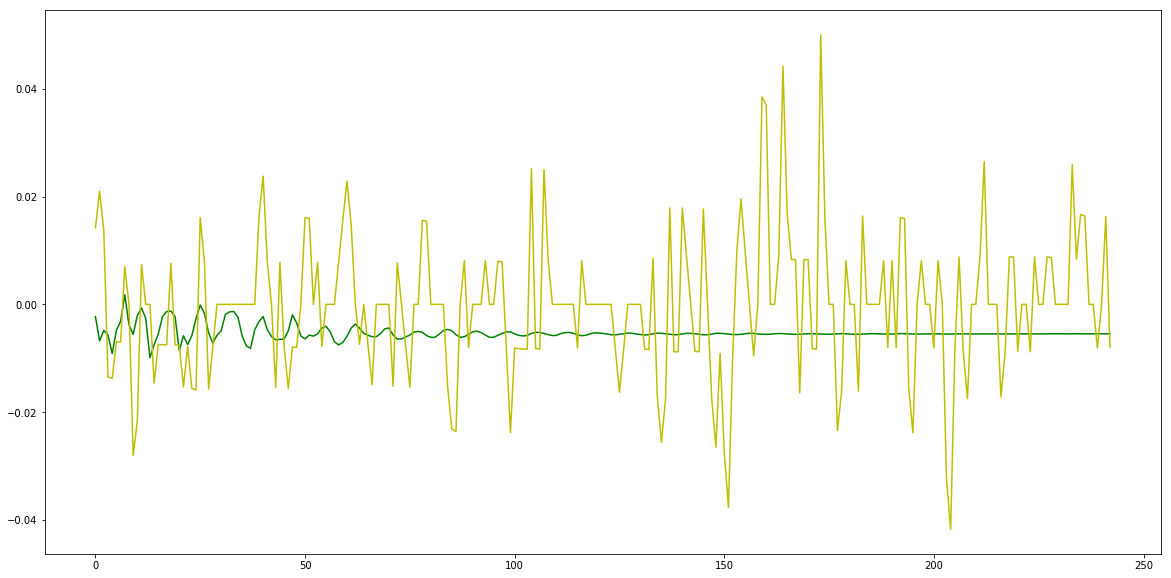

TU


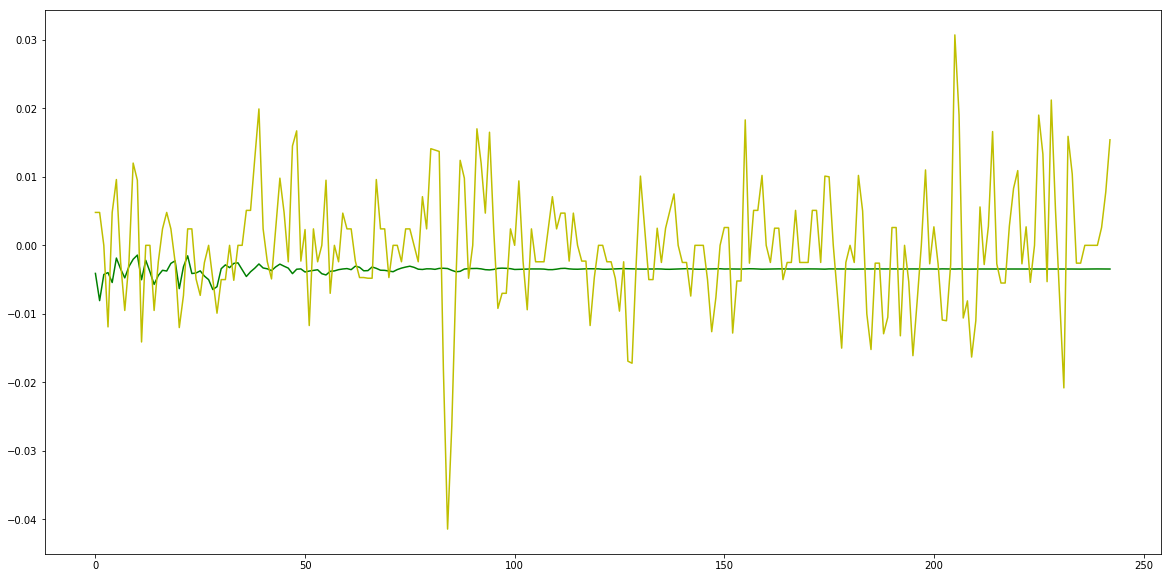

In [22]:
for i in range(len(SET50)):
    print(SET50[i])
    data1 = get_data_from_nparray(predicts[0], i)
    data4 = get_data_from_nparray(y_test, i)
    plot_graph(data1, data4)

In [ ]:
3(conv)*3(fc)*3(convsize)*2(fcsize)

3lstm